<h1 style="text-align: center;">Extracting pre-stimulus parameters - Fooof and Alpha power</h1>
<h2 style="text-align: center;">This notebook puts all the extracted data into an excel sheet</h2>



In [1]:
########################################### This script is for the extraction of spectral parameters from the data ###########################################
########################################### The extracted data is all saved in a pickle file for each subject ###########################################
import numpy as np
import os
import matplotlib.pyplot as plt
from fooof import FOOOF
from fooof import FOOOFGroup
import pickle
import pandas as pd
import mne
from scipy.signal import detrend as scipy_detrend
from scipy.signal import ShortTimeFFT as STFT
import scipy.signal as signal
from scipy.fftpack import fft

/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_46263/2796532653.py:6: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [28]:
########### You have to decide whether to use multitaper or custom function ############


def get_alpha(epochs):
    psd = epochs.compute_psd(method='multitaper', fmin=7, fmax=12, tmin=-1, tmax=0, bandwidth=2.0)
    spectra, freqs = psd.get_data(return_freqs=True)
    return spectra, freqs

# Extract pre-stimulus data
def extract_tapered_psd(epochs, tmin = -1.0, tmax = 0.0, pad_duration = 1.0):
    pre_stim_data = epochs.copy().crop(tmin=tmin, tmax=tmax).get_data()
    n_epochs, n_channels, n_times = pre_stim_data.shape
    sfreq = epochs.info['sfreq']

    n_pad = int(pad_duration * sfreq)
    window = np.hanning(n_times).reshape(1, 1, n_times)
    tapered_data = pre_stim_data * window
    padded_data = np.pad(tapered_data, pad_width=((0, 0), (0, 0), (0, n_pad)), mode='constant')

    # Compute FFT
    freqs = np.fft.rfftfreq(n_times + n_pad, d=1/sfreq)
    fft_data = np.fft.rfft(padded_data, axis=-1)
    psd = np.abs(fft_data)**2
    psd /= ((n_times + n_pad) * np.sum(window[0, 0, :]**2))  # Normalize by duration and window energy
    psd[..., 1:-1] *= 2  # Correct for one-sided FFT

    maxfreq_idx = np.argmin(np.abs(freqs - 30))
    psd = psd[:,:,:maxfreq_idx+1]
    freqs = freqs[:maxfreq_idx+1]
    return psd, freqs

########### Do we want Fixed or Knee? ############ 
def FitFooof(epochs, freq_range=[1, 30], Dat2use = 'Custom'):
    # Extract Spectral Power Density
    start = -1
    stop = 0
    pad_duration = 1.0 # padding duration in seconds - Remember to determine what this will be

    if Dat2use == 'MNE':
        # Extract spectrum using MNE function - Low frequency resolution
        psd = epochs.compute_psd(method='multitaper', fmin=0, fmax=30.0, tmin=start, tmax=stop, bandwidth=2.0)
        spectra, freqs = psd.get_data(return_freqs=True)
    elif Dat2use == 'Custom':
        # Extract spectrum using custom function - Higher frequency resolution
        spectra, freqs = extract_tapered_psd(epochs, tmin=start, tmax=stop, pad_duration=pad_duration)

    # Initialize a dictionary to store results for each trial and channel
    freq_range = [1, 30]
    results_dict = {}

    # Loop over each trial
    for trial in range(spectra.shape[0]):
        # Loop over each channel
        for channel in range(spectra.shape[1]):
            # Get the spectrum for the current trial and channel
            spectra_slice = spectra[trial, channel, :]
            
            # Initialize and fit the FOOOF model
            fm = FOOOF(peak_width_limits=[1, 15], max_n_peaks=3, aperiodic_mode='fixed')
            fm.fit(freqs, spectra_slice, freq_range)
            
            # Store the results in the dictionary with keys for trial and channel
            results_dict[(trial, channel)] = {
                'aperiodic_params': fm.aperiodic_params_,
                'peak_params': fm.peak_params_,
                'r_squared': fm.r_squared_,
                'error': fm.error_,
                'gaussian_params': fm.gaussian_params_
            }
    # Extract the alpha power and frequency and store in the same dictionary
    alpha_power, alpha_freq = get_alpha(epochs)
    results_dict['alpha_power'] = alpha_power
    results_dict['alpha_freq'] = alpha_freq
    return results_dict


102

In [ ]:

# Load and detrend the data
from Path_Config import Processed_folder as directory_path
files = os.listdir(directory_path)
to_process = []
for f in files:
    name, ext = os.path.splitext(f)
    if ext == '.set':
        to_process.append(f)
len(to_process)

errors = []
subfolder_name = 'Features_Thesis'
Write_path = os.path.join(directory_path, subfolder_name)
if not os.path.exists(Write_path):
    os.makedirs(Write_path)
    print(f"Subfolder created at: {Write_path}")
else:
    print(f"Subfolder already exists at: {Write_path}")

for this_subject in range(len(to_process)):
    try:
        # Check that it doesnt start with a .
        if not to_process[this_subject].startswith('.'):
            epochs = mne.io.read_epochs_eeglab(directory_path + to_process[this_subject])
        else:
            continue
        data = epochs.get_data()
        data *= 1e6

        # Detrend the data
        data_detrended = scipy_detrend(data, axis=-1, type='linear')

        # Create new epochs with the detrended data
        epochs = mne.EpochsArray(data_detrended, epochs.info, events=epochs.events, event_id=epochs.event_id, tmin=epochs.tmin)
        del data, data_detrended
        # Baseline correct the epochs
        
        # Fit the FOOF algorithm and extract prestim alpha
        results_dict = FitFooof(epochs, Dat2use='Custom')
        
        epochs.apply_baseline((-.5, 0))
        freqs = np.arange(1, 31, 1)
        n_cycles = freqs / 2.0
        # time frequency extraction
        tfr = epochs.compute_tfr('morlet', freqs,
                   tmin=None, tmax=None, picks=None, 
                   output='power', average=False, 
                   return_itc=False, decim=1, use_fft=True,
                   verbose=None, n_cycles=n_cycles)
        tfr.apply_baseline((-1, -.2), mode='mean')
        tfr.save(Write_path + '/' + to_process[this_subject].split('.')[0][:8] + '_tfr.h5', overwrite=True)
        
        # Extract the S1 and S2 power
        # For theta band (4-8Hz) gating, extract 0 to 400 relative to each stimulus
        # Second stimulus occurs at 0.5s for Somatosensory and at .65 for respiratory
        # Then we calculate gating as the ratio of S2/S1
        if 'GFAR' in to_process[this_subject]:
            tmin = .65
        elif 'GFAS' in to_process[this_subject]:
            tmin = .5
        S1 = tfr.get_data(fmin=4, fmax=8, tmin=0, tmax=0.4).mean(axis=(-1, -2))
        S2 = tfr.get_data(fmin=4, fmax=8, tmin=tmin, tmax=tmin+0.4).mean(axis=(-1, -2))
        gating = S2/S1
        results_dict['theta_gating'] = gating

        # Save the dictionary to a pickle file
        foof_filename = to_process[this_subject].split('.')[0][:8] + '_fooof.pkl'
        with open(Write_path + '/' + foof_filename, 'wb') as f: # Make sure to store this separately for each participant
            pickle.dump(results_dict, f)
        del results_dict
    except:
        errors.append(this_subject)

print(f'THE FOLLOWING FILES HAD ERRORS:')
for e in errors:
    print(to_process[e])

GFAS_044_fooof.pkl


In [ ]:
# Load the foof files again and add the new gating information to it
# Load and detrend the data
from Path_Config import Processed_folder as directory_path
files = os.listdir(directory_path)
to_process = []
for f in files:
    name, ext = os.path.splitext(f)
    if ext == '.set':
        to_process.append(f)
len(to_process)

errors = []
epsilon = 1e-10
subfolder_name = 'Features_Thesis'
Write_path = os.path.join(directory_path, subfolder_name)
if not os.path.exists(Write_path):
    os.makedirs(Write_path)
    print(f"Subfolder created at: {Write_path}")
else:
    print(f"Subfolder already exists at: {Write_path}")

for this_subject in range(len(to_process)):
    try:
        # Check that it doesnt start with a .
        if not to_process[this_subject].startswith('.'):
            epochs = mne.io.read_epochs_eeglab(directory_path + to_process[this_subject])
        else:
            continue
        data = epochs.get_data()
        data *= 1e6

        # Detrend the data
        data_detrended = scipy_detrend(data, axis=-1, type='linear')

        # Create new epochs with the detrended data
        epochs = mne.EpochsArray(data_detrended, epochs.info, events=epochs.events, event_id=epochs.event_id, tmin=epochs.tmin)
        del data, data_detrended
        # Baseline correct the epochs
        
        epochs.apply_baseline((-.5, 0))
        freqs = np.arange(1, 31, 1)
        n_cycles = freqs / 2.0
        # time frequency extraction
        tfr = epochs.compute_tfr('morlet', freqs,
                   tmin=None, tmax=None, picks=None, 
                   output='power', average=False, 
                   return_itc=False, decim=1, use_fft=True,
                   verbose=None, n_cycles=n_cycles)
        # tfr.save(Write_path + '/' + to_process[this_subject].split('.')[0][:8] + '_tfr.h5', overwrite=True)
        
        # Extract the S1 and S2 power
        # For theta band (4-8Hz) gating, extract 0 to 400 relative to each stimulus
        # Second stimulus occurs at 0.5s for Somatosensory and at .65 for respiratory
        # Then we calculate gating as the ratio of S2/S1
        if 'GFAR' in to_process[this_subject]:
            tmin = .65
        elif 'GFAS' in to_process[this_subject]:
            tmin = .5
        S1 = tfr.get_data(fmin=4, fmax=8, tmin=0, tmax=0.4).mean(axis=(-1, -2))
        S2 = tfr.get_data(fmin=4, fmax=8, tmin=tmin, tmax=tmin+0.4).mean(axis=(-1, -2))
        Nobase_gating_div = S2/ (S1 + epsilon)
        Subtraction_gating_nobase = S2 - S1

        # Apply ratio and percent baseline correction
        TFR_ratio_base = tfr.copy().apply_baseline((-1, -.2), mode='ratio')
        TFR_Percent_base = tfr.copy().apply_baseline((-1, -.2), mode='percent')


        S1 = TFR_ratio_base.get_data(fmin=4, fmax=8, tmin=0, tmax=0.4).mean(axis=(-1, -2))
        S2 = TFR_ratio_base.get_data(fmin=4, fmax=8, tmin=tmin, tmax=tmin+0.4).mean(axis=(-1, -2))
        Ratio_Base_gating = S2/ (S1 + epsilon)
        Subtraction_gating_ratiobase = S2 - S1


        S1 = TFR_Percent_base.get_data(fmin=4, fmax=8, tmin=0, tmax=0.4).mean(axis=(-1, -2))
        S2 = TFR_Percent_base.get_data(fmin=4, fmax=8, tmin=tmin, tmax=tmin+0.4).mean(axis=(-1, -2))
        Percent_Base_gating = S2/ (S1 + epsilon)
        Subtraction_gating_percentbase = S2 - S1

         # Load the results dictionary
        foof_filename = to_process[this_subject].split('.')[0][:8] + '_fooof_gating.pkl'
        new_results_dict = {}

        # Add the gating information to the results dictionary
        new_results_dict['theta_gating_nobase'] = Nobase_gating_div
        new_results_dict['theta_gating_subtraction_nobase'] = Subtraction_gating_nobase
        new_results_dict['theta_gating_ratio_base'] = Ratio_Base_gating
        new_results_dict['theta_gating_subtraction_ratiobase'] = Subtraction_gating_ratiobase
        new_results_dict['theta_gating_percent_base'] = Percent_Base_gating
        new_results_dict['theta_gating_subtraction_percentbase'] = Subtraction_gating_percentbase


        # Save the dictionary to a pickle file
        with open(Write_path + '/' + foof_filename, 'wb') as f: # Make sure to store this separately for each participant
            pickle.dump(new_results_dict, f)
        del new_results_dict
    except:
        errors.append(this_subject)

print(f'THE FOLLOWING FILES HAD ERRORS:')
for e in errors:
    print(to_process[e])

In [ ]:
################################## Extract gating information and Alpha/Exponent and fit model for all channels ##################################
from statsmodels.api import MixedLM
import statsmodels.formula.api as smf
from Path_Config import Processed_folder as Path
# Extract all .pkl files
pkl_files = [f for f in os.listdir(Path) if f.endswith('.pkl') and 'gating' not in f]
pkl_new = [f for f in os.listdir(Path) if f.endswith('.pkl') and 'gating' in f]
Sample_epochs = mne.io.read_epochs_eeglab(Path + 'GFAR_005_baseline.set')
# Make sure that they are in the same order
pkl_files.sort()
pkl_new.sort()

channel2xtract_GFAR = 128
channel2xtract_GFAS = 103
predictor_chans = np.arange(len(Sample_epochs.ch_names))
print(predictor_chans)
for predictor_chan in predictor_chans:
    for index in range(len(pkl_files)):
        assert pkl_files[index].split('_')[0] == pkl_new[index].split('_')[0], "The participant names do not match"
        with open(Path + '/' + pkl_files[index], 'rb') as f: 
            results_dict = pickle.load(f)
        Condition = pkl_files[index].split('_')[0]
        Participant = pkl_files[index][:8]
        print(f'Condition: {Condition}')
        print(f'Participant: {Participant}')
        print(f'File_Old: {pkl_files[index]}')
        print(f'File_New: {pkl_new[index]}')

        with open(Path + '/' + pkl_new[index], 'rb') as f:
            new_results_dict = pickle.load(f)

        numtrials = len(results_dict['alpha_power'])
        if 'GFAR' in Condition:
            channel2xtract = channel2xtract_GFAR
        elif 'GFAS' in Condition:
            channel2xtract = channel2xtract_GFAS
        alpha_power = results_dict['alpha_power'][:,predictor_chan,:].mean(axis=1)
        print(f'alpha_power shape: {alpha_power.shape}')
        Exponents = []
        Offsets = []
        for trial in range(numtrials):
            tempdata = results_dict[(trial, predictor_chan)]
            # aperiodic_params, peak_params, r_squared, error, gaussian_params
            aperiodic_params = tempdata['aperiodic_params']
            Exponents.append(aperiodic_params[1])
            Offsets.append(aperiodic_params[0])
        Exponents = np.array(Exponents)
        Offsets = np.array(Offsets)
        Nobase_gating_div = new_results_dict['theta_gating_nobase'][:,channel2xtract]
        Subtraction_gating_nobase = new_results_dict['theta_gating_subtraction_nobase'][:,channel2xtract]
        Ratio_Base_gating = new_results_dict['theta_gating_ratio_base'][:,channel2xtract]
        Subtraction_gating_ratiobase = new_results_dict['theta_gating_subtraction_ratiobase'][:,channel2xtract]
        Percent_Base_gating = new_results_dict['theta_gating_percent_base'][:,channel2xtract]
        Subtraction_gating_percentbase = new_results_dict['theta_gating_subtraction_percentbase'][:,channel2xtract]

        assert len(Percent_Base_gating) == Exponents.shape[0] == Offsets.shape[0] == alpha_power.shape[0] == len(Nobase_gating_div), "The lengths of the arrays do not match"

        data = []
        for trial in range(numtrials):
            trial_data = {
                "Participant": Participant,
                "Condition": Condition,
                "Trial": trial + 1,
                "Exponent": Exponents[trial],
                "Alpha_Power": alpha_power[trial],
                "Gating": Ratio_Base_gating[trial]
                # "Nobase_gating_div": Nobase_gating_div[trial],
                # "Nobase_gating_subtraction": Subtraction_gating_nobase[trial],
                # "Ratio_base_subtraction": Subtraction_gating_ratiobase[trial],
                # "Percent_base_gating_div": Percent_Base_gating[trial],
                # "Percent_base_subtraction": Subtraction_gating_percentbase[trial],
            }
            data.append(trial_data)
        df = pd.DataFrame(data)
        if index == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], ignore_index=True)

    # df_all.head()
    df_all = df_all[df_all['Gating'] <= 3]
    assert df_all['Gating'].max() <= 3, "The gating values are greater than 3"
    assert df_all['Gating'].min() >= 0, "The gating values are less than 0"
    df_GFAR = df_all[df_all['Condition'] == 'GFAR']
    df_GFAS = df_all[df_all['Condition'] == 'GFAS']


    # fit a hierarchical LMM to see whether alpha power and exponent predict gating
    # Fit LMM for alpha power
    model_alpha = smf.mixedlm("Gating ~ Alpha_Power", data=df_GFAR, groups=df_GFAR["Participant"])
    model_alpha_result = model_alpha.fit()
    alpha_coef = model_alpha_result.fe_params['Alpha_Power']
    alpha_p = model_alpha_result.pvalues['Alpha_Power']

    # Fit LMM for exponent
    model_exponent = smf.mixedlm("Gating ~ Exponent", data=df_GFAR, groups=df_GFAR["Participant"])
    model_exponent_result = model_exponent.fit()
    exponent_coef = model_exponent_result.fe_params['Exponent']
    exponent_p = model_exponent_result.pvalues['Exponent']

    # Store results in a dataframe
    results_GFAR = pd.DataFrame({
        'Channel': [predictor_chan],
        'Alpha_Power': [alpha_coef],
        'Exponent': [exponent_coef],
        'Alpha_Power_p': [alpha_p],
        'Exponent_p': [exponent_p]
    })

    # fit a hierarchical LMM to see whether alpha power and exponent predict gating
    # Fit LMM for alpha power
    model_alpha = smf.mixedlm("Gating ~ Alpha_Power", data=df_GFAS, groups=df_GFAS["Participant"])
    model_alpha_result = model_alpha.fit()
    alpha_coef = model_alpha_result.fe_params['Alpha_Power']
    alpha_p = model_alpha_result.pvalues['Alpha_Power']

    # Fit LMM for exponent
    model_exponent = smf.mixedlm("Gating ~ Exponent", data=df_GFAS, groups=df_GFAS["Participant"])
    model_exponent_result = model_exponent.fit()
    exponent_coef = model_exponent_result.fe_params['Exponent']
    exponent_p = model_exponent_result.pvalues['Exponent']

    # Store results in a dataframe
    results_GFAS = pd.DataFrame({
        'Channel': [predictor_chan],
        'Alpha_Power': [alpha_coef],
        'Exponent': [exponent_coef],
        'Alpha_Power_p': [alpha_p],
        'Exponent_p': [exponent_p]
    })

    # Now concatenate the results for all channels (separately for GFAR and GFAS)
    if predictor_chan == 0:
        All_results_GFAR = results_GFAR
        All_results_GFAS = results_GFAS
    else:
        All_results_GFAR = pd.concat([All_results_GFAR, results_GFAR], ignore_index=True)
        All_results_GFAS = pd.concat([All_results_GFAS, results_GFAS], ignore_index=True)



# # Save to excel
# df_all.to_excel(Path + 'Extracted_Features_Pauline_Parietal_Chans.xlsx', index=False)

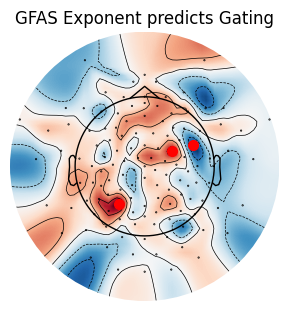

In [66]:
# Create a topography of the alpha power and exponent
data = All_results_GFAS
mask = data['Exponent_p'] < 0.05
mne.viz.plot_topomap(
    data['Exponent'], Sample_epochs.info,
    ch_type='eeg', sensors=True, names=None, mask=mask, 
    mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='r',
                     linewidth=0, markersize=7),
    contours=6, outlines='head', sphere=None, 
    image_interp='cubic', extrapolate='head', 
    border='mean', res=64, size=3, cmap=None, vlim=(None, None), 
    cnorm=None, axes=None, show=False, onselect=None  # <- show=False is important
)

plt.title('GFAS Exponent predicts Gating')
plt.show()